In [196]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'C:/Users/Lukas Chin/Desktop/cats_dogs/train'
TEST_DIR = 'C:/Users/Lukas Chin/Desktop/cats_dogs/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [191]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]
    

In [192]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [193]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    return testing_data

In [194]:
#train_data = create_train_data()

train_data = np.load('train_data.npy', allow_pickle=True)

In [178]:
# import tflearn
# from tflearn.layers.conv import conv_2d, max_pool_2d
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.estimator import regression

# from tensorflow.python.framework import ops
# ops.reset_default_graph()

# convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

# convnet = conv_2d(convnet, 32, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = conv_2d(convnet, 64, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = conv_2d(convnet, 32, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = conv_2d(convnet, 64, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = conv_2d(convnet, 32, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = conv_2d(convnet, 64, 7, activation='relu')
# convnet = max_pool_2d(convnet, 7)

# convnet = fully_connected(convnet, 1024, activation='relu')
# convnet = dropout(convnet, 0.8)

# convnet = fully_connected(convnet, 2, activation='softmax')
# convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

# model = tflearn.DNN(convnet, tensorboard_dir='log')

In [197]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

from tensorflow.python.framework import ops
ops.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
# conv layer 1 w/max pooling
conv1 = conv_2d(convnet, 32, 2, activation='relu')
conv1 = max_pool_2d(conv1, 2)
# conv layer 2 w/max pooling etc
conv2 = conv_2d(conv1, 64, 2, activation='relu')
conv2 = max_pool_2d(conv2, 2)

conv3 = conv_2d(conv2, 64, 2, activation='relu')
conv3 = max_pool_2d(conv3, 2)

conv4 = conv_2d(conv3, 128, 2, activation='relu')
conv4 = max_pool_2d(conv4, 2)

conv5 = conv_2d(conv4, 128, 2, activation='relu')
conv5 = max_pool_2d(conv5, 2)

conv6 = conv_2d(conv5, 256, 2, activation='relu')
conv6 = max_pool_2d(conv6, 2)

conv7 = conv_2d(conv6, 256, 2, activation='relu')
conv7 = max_pool_2d(conv7, 2)

conv8 = conv_2d(conv7, 512, 2, activation='relu')
conv8 = max_pool_2d(conv8, 2)
# fully connected layer
fc1 = fully_connected(conv8, 1024, activation='relu')
fc1 = dropout(fc1, 0.8)
# fc2
fc2 = fully_connected(fc1, 128, activation='relu')
fc2 = dropout(fc2, 0.8)
# output layer for classification
output = fully_connected(fc2, 2, activation='softmax')
output = regression(output, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(output, tensorboard_dir='log')     # logs to temp file for tensorboard analysis

In [195]:
from tflearn.layers.conv import conv_2d, max_pool_2d, residual_block, batch_normalization
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn
import tensorflow as tf
from tensorflow.python.framework import ops
from tflearn.data_augmentation import ImageAugmentation
import scipy

def conv_res_integrated(img_size, lr, n, img_aug):
    ops.reset_default_graph()

    convnet = input_data(shape=[None, img_size, img_size, 1], name='input', data_augmentation=img_aug)
    # conv layer 1 w/max pooling
    conv1 = conv_2d(convnet, 32, 2, activation='relu', regularizer='L2', weight_decay=0.0001)
    conv1 = max_pool_2d(conv1, 2)
    # conv layer 2 w/max pooling etc
    conv2 = conv_2d(conv1, 32, 2, activation='relu', regularizer='L2', weight_decay=0.0001)
    conv2 = max_pool_2d(conv2, 2)

    conv3 = conv_2d(conv2, 64, 2, activation='relu', regularizer='L2', weight_decay=0.0001)
    conv3 = max_pool_2d(conv3, 2)

    conv4 = conv_2d(conv3, 64, 2, activation='relu', regularizer='L2', weight_decay=0.0001)
    conv4 = max_pool_2d(conv4, 2)
    # residual block
    res1 = residual_block(conv4, n, 128, downsample=True, regularizer='L2', weight_decay=0.0001)
    batch_norm = batch_normalization(res1)
    activ = tflearn.activation(batch_norm, 'relu')
    gap = tflearn.global_avg_pool(activ)
    # fully connected layer 1
    fc1 = fully_connected(gap, 1024, activation='relu', regularizer='L2', weight_decay=0.0001)
    fc1 = dropout(fc1, 0.85)
    # fully connected layer 2
    fc2 = tflearn.fully_connected(fc1, 2, activation='softmax')
    # output layer
    mom = tflearn.Momentum(0.1, lr_decay=0.01, decay_step=32000, staircase=True)
    output = tflearn.regression(fc2, optimizer=mom, learning_rate=lr, loss='categorical_crossentropy')
    # Training
    model = tflearn.DNN(output, checkpoint_path='model_integrated',
                        max_checkpoints=2, tensorboard_verbose=0,
                        tensorboard_dir='log', clip_gradients=0.)
    return model

img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

model = conv_res_integrated(img_size=IMG_SIZE, lr=LR, n=1, img_aug=img_aug)

NotImplementedError: 'variance_scaling_initializer' not supported, please update TensorFlow.

In [133]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\Lukas Chin\Desktop\cats_dogs\dogsvscats-0.002-6conv-basic.model
model loaded!


In [156]:
train = train_data[:-500]
test = train_data[-500:]

In [157]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train] 

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test])

In [198]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

acc = round(model.evaluate(test_x,test_y)[0]*100, 2)

with open('machine-info.csv','a') as f:
    f.write('{},{},{},{}\n'.format(LR,8,2,acc))

print('Accuracy: {}%'.format(acc))

Training Step: 3829  | total loss: 0.27845 | time: 53.183s
| Adam | epoch: 010 | loss: 0.27845 - acc: 0.8818 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.28421 | time: 54.326s
| Adam | epoch: 010 | loss: 0.28421 - acc: 0.8764 | val_loss: 0.45601 - val_acc: 0.7980 -- iter: 24500/24500
--
Accuracy: 79.8%


In [98]:
acc = model.evaluate(test_x,test_y)

print('Accuracy: {}'.format(acc))

Accuracy: [0.7720000066757202]


In [132]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Lukas Chin\Desktop\cats_dogs\dogsvscats-0.002-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:C:\Users\Lukas Chin\Desktop\cats_dogs\dogsvscats-0.002-6conv-basic.model.data-00000-of-00001
INFO:tensorflow:2800
INFO:tensorflow:C:\Users\Lukas Chin\Desktop\cats_dogs\dogsvscats-0.002-6conv-basic.model.index
INFO:tensorflow:2800
INFO:tensorflow:C:\Users\Lukas Chin\Desktop\cats_dogs\dogsvscats-0.002-6conv-basic.model.meta
INFO:tensorflow:3000


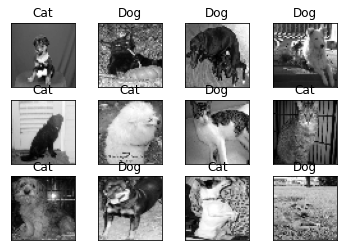

In [87]:
import matplotlib.pyplot as plt

#test_data = process_test_data()
test_data = np.load('test_data.npy', allow_pickle=True)

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat : [1,0]
    #dog : [0,1]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [30]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

In [31]:
with open('submission-file.csv','w') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:29<00:00, 424.65it/s]


In [102]:
with open('machine-info.csv','a') as f:
    f.write('\n{},{},{},{}\n'.format('Learning Rate', '# Convnet','-','Accuracy'))